In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

from tensorflow.keras import models, layers

In [4]:

!pip install wandb

In [5]:
data_dir = "/content/drive/MyDrive/archive(12)/Brain MRI"

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    labels="inferred",
    label_mode="int",  # Use "categorical" if you want one-hot encoding
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),  # Resize all images to this size
    batch_size=32
)

Found 58 files belonging to 2 classes.
Using 47 files for training.


In [6]:
len(dataset)

2

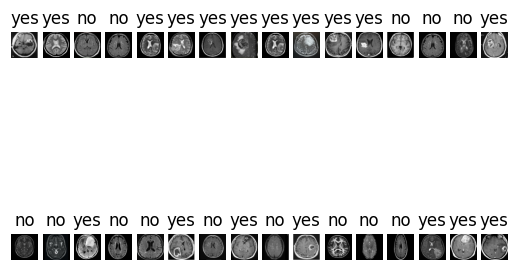

In [7]:
import matplotlib.pyplot as plt

# Assuming 'train_dataset' is your dataset object
for images, labels in dataset:  # Take one batch from the dataset
    for i in range(images.shape[0]):  # Iterate through images in the batch
        ax = plt.subplot(2, 16, i + 1)  # Create subplots for display
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.title(dataset.class_names[labels[i].numpy()])  # Set title with label
        plt.axis("off")  # Hide axis ticks

plt.show()  # Show the plot with all images and labels

In [8]:

def split_data(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    # Create the train dataset
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    print(list(train_dataset.as_numpy_iterator()))

    # Create the validation and test datasets
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

    return train_dataset, val_dataset, test_dataset


In [9]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = split_data(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.as_numpy_iterator()),
      list(val_dataset.as_numpy_iterator()),
      list(test_dataset.as_numpy_iterator()))

[(array([[[[252.03247  , 252.03247  , 252.03247  ],
         [219.54224  , 219.54224  , 219.54224  ],
         [217.54639  , 217.54639  , 217.54639  ],
         ...,
         [218.05908  , 218.05908  , 218.05908  ],
         [218.93188  , 218.93188  , 218.93188  ],
         [250.73877  , 250.73877  , 250.73877  ]],

        [[235.0813   , 235.0813   , 235.0813   ],
         [ 18.739258 ,  18.739258 ,  18.739258 ],
         [  8.126465 ,   8.126465 ,   8.126465 ],
         ...,
         [ 10.473877 ,  10.473877 ,  10.473877 ],
         [ 17.011963 ,  17.011963 ,  17.011963 ],
         [229.48901  , 229.48901  , 229.48901  ]],

        [[234.56836  , 234.56836  , 234.56836  ],
         [ 12.802734 ,  12.802734 ,  12.802734 ],
         [  1.6784668,   1.6784668,   1.6784668],
         ...,
         [  1.6247559,   1.6247559,   1.6247559],
         [ 10.645752 ,  10.645752 ,  10.645752 ],
         [228.94849  , 228.94849  , 228.94849  ]],

        ...,

        [[234.47168  , 234.47168  , 

In [10]:
def preprocess(image, label):
    # Ensure binary labels (e.g., 0 or 1)
    label = tf.cast(label > 0, tf.int32)  # Force labels to 0 or 1
    return image, label

train_dataset = train_dataset.map(preprocess)

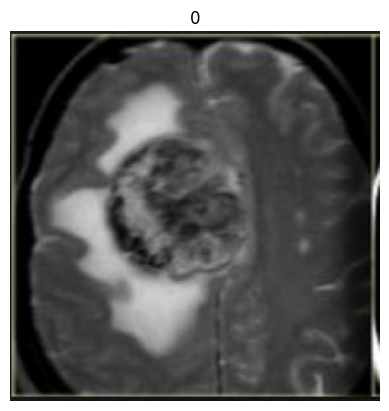

In [11]:
import matplotlib.pyplot as plt

# Iterate over the first 16 images in the training dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(1, 1, i + 1)

    # Select a single image from the batch
    single_image = image[0].numpy()  # Get the first image from the batch
    plt.imshow(single_image.astype('uint8'))  # Convert to uint8 for correct color rendering

    # Assuming you have a label map, or use a string conversion
    # plt.title(str(label.numpy()))
    plt.title(str(tf.argmax(label, axis=-1).numpy()))  #  # Show label as text
    plt.axis('off')  # Hide axis

    import matplotlib.pyplot as plt



In [12]:
num_samples = len(list(dataset))
print("Number of samples in train_dataset:", num_samples)

Number of samples in train_dataset: 2


ValueError: num must be an integer with 1 <= num <= 16, not 17

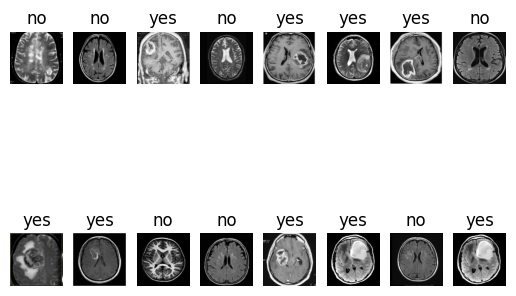

In [13]:
# Assuming 'train_dataset' is your dataset object
for images, labels in train_dataset:  # Take one batch from the dataset
    for i in range(images.shape[0]):  # Iterate through images in the batch
        ax = plt.subplot(2, 8, i + 1)  # Create subplots for display
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.title(dataset.class_names[labels[i].numpy()])  # Set title with label
        plt.axis("off")  # Hide axis ticks

plt.show()

In [38]:
IM_SIZE=224
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255)
])

In [14]:
# The above code is only for resize and now the below code will resize and rescale the image simultaneously
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0, label

In [15]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, strides=1, padding='valid', activation = 'sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 5, strides=1, padding='valid', activation = 'sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(1000, activation = 'sigmoid'),
    BatchNormalization(),
    Dense(100, activation = 'sigmoid'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │      44,945,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,052,561 (171.86 MB)

 Trainable params: 45,050,317 (171.85 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255)
])

In [16]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501),),
    # or we can use t.image here like this
    # RotNinety(),
    RandomFlip(mode='horizontal', )
])

def augment_layer(image, labels):
  return augment_layers(resize_rescle_layers(image), training = True), label

In [17]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    input_size = input_features_shape[-1]
    self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units),
                                 initializer="glorot_uniform", trainable=True)
    self.b = self.add_weight(shape=(self.output_units,), initializer="zeros", trainable=True)

  def call(self, input_features):

    print("Input shape:", input_features.shape)

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [18]:
IM_SIZE = 224
dropout_rate = 0.2
regularization_rate = 0.01
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
                             #after adding resize_rescale_layers the input layer would be like
                             # InputLayer(input_shape = (None, None, 3)),

                             # we can add resclaing in the model itself so that we do no need to do it separately everytime
                             # resize_rescle_layers,
                             # augment_layers,
                             # after affding here we can remove the map from train and val datasets



                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu',kernel_regularizer = L2(regularization_rate)),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),
                             Dropout(rate = dropout_rate),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),

                             NeuralearnDense(100, activation = "relu"),
                             BatchNormalization(),
                             Dropout(rate= dropout_rate),

                             NeuralearnDense(10, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(1, activation = "sigmoid"),

])
lenet_custom_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Input shape: (None, 46656)
Input shape: (None, 100)
Input shape: (None, 10)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense (NeuralearnDense)   │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_1 (NeuralearnDense) │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_2 (NeuralearnDense) │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [19]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr*tf.math.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [20]:
es_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [21]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print('\n For Epoch Number {} the model has a loss of {}'.format(epoch, logs['loss']))

  def on_batch_end(self, batch, logs):
    print('\n For Batch Number {} the model has a loss of {}'.format(batch+1, logs))

In [22]:
csv_callback = CSVLogger(
    'logs.csv', separator = ',', append=False
)

In [25]:
history = lenet_custom_model.fit(train_dataset, validation_data = val_dataset, epochs = 3, verbose=1, callbacks=[LossCallback(),scheduler_callback,csv_callback,es_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/3

 For Batch Number 1 the model has a loss of {'accuracy': 0.84375, 'loss': 0.34673139452934265}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8438 - loss: 0.3467
 For Epoch Number 0 the model has a loss of 0.34673139452934265
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8438 - loss: 0.3467 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/3


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)



 For Batch Number 1 the model has a loss of {'accuracy': 0.84375, 'loss': 0.34982648491859436}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8438 - loss: 0.3498
 For Epoch Number 1 the model has a loss of 0.34982648491859436
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8438 - loss: 0.3498 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/3

 For Batch Number 1 the model has a loss of {'accuracy': 0.84375, 'loss': 0.3824097514152527}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8438 - loss: 0.3824
 For Epoch Number 2 the model has a loss of 0.3824097514152527
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8438 - loss: 0.3824 - learning_rate: 0.0100


In [23]:
lenet_custom_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics=['accuracy'])
              #metrics = RootMeanSquaredError())

In [ ]:
for image, label in test_dataset.take(1):  # Take one sample from the dataset
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)

Image shape: (15, 224, 224, 3)
Label shape: (15,)


In [ ]:
unbatched_dataset = test_dataset.unbatch()

In [ ]:
for image, label in unbatched_dataset.take(1):  # Take one sample from the dataset
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)

Image shape: (224, 224, 3)
Label shape: ()


In [ ]:
for images, labels in unbatched_dataset.take(1):  # Take one batch
    single_image = images  # Get the first image from the batch
    single_image = tf.expand_dims(single_image, axis=0)  # Add batch dimension
    prediction = model.predict(single_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [ ]:
labels = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)



In [ ]:
print(len(labels))
print(labels)

1
[array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int32)]


In [ ]:

labels = np.array([i[0] for i in labels])
print(labels)

[1]


In [26]:
predicted = lenet_custom_model.predict(test_dataset.take(1))[0:]
print(predicted.shape)
predicted = np.array(predicted)
labels = np.array(labels)

Input shape: (15, 46656)
Input shape: (15, 100)
Input shape: (15, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
(15, 1)


In [27]:
print(labels)

[0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0]


In [28]:
print(predicted)

[[0.99999636]
 [0.99569184]
 [0.9952795 ]
 [0.99991214]
 [0.9441664 ]
 [0.98600376]
 [0.99974865]
 [0.99962896]
 [0.9999816 ]
 [0.9897638 ]
 [0.960967  ]
 [0.999991  ]
 [0.9991588 ]
 [0.9999001 ]
 [0.9863859 ]]


In [33]:
predicted = predicted.flatten()  # Now shape: (15,)
labels = labels.flatten()

In [32]:
min_length = min(len(labels), len(predicted))
labels = labels[:min_length]
predicted = predicted[:min_length]

[[0 7]
 [0 8]]


Text(0.5, 47.7222222222222, 'Predicted')

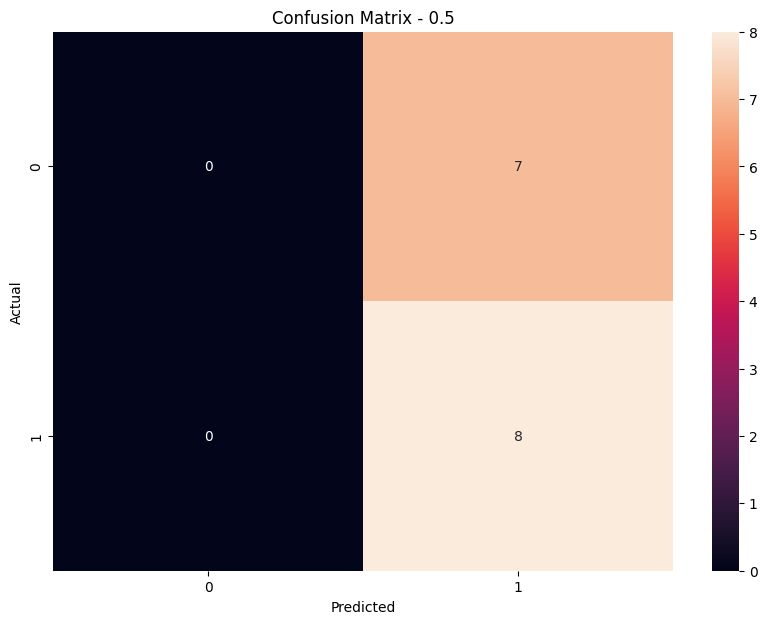

In [34]:
threshold =0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix - {}".format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [35]:
print("Predicted classes shape:", predicted.shape)
print("Labels shape:", labels.shape)

Predicted classes shape: (15,)
Labels shape: (15,)


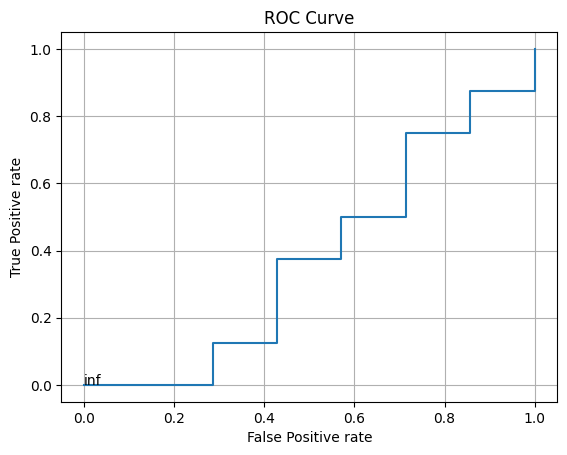

In [36]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.title("ROC Curve")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics=metrics)

In [ ]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 3, verbose=1, callbacks=[])

Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6875 - auc: 0.6484 - fn: 6.0000 - fp: 4.0000 - loss: 0.7430 - precision: 0.7143 - recall: 0.6250 - tn: 12.0000 - tp: 10.0000
Epoch 2/3


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9375 - auc: 0.9490 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.2869 - precision: 0.8947 - recall: 1.0000 - tn: 13.0000 - tp: 17.0000
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2812 - auc: 0.3075 - fn: 15.0000 - fp: 8.0000 - loss: 1.7774 - precision: 0.2727 - recall: 0.1667 - tn: 6.0000 - tp: 3.0000


In [41]:
image = cv2.imread('/content/30 no.jpg')
image = cv2.resize(image, (224, 224))
#print(image.shape)
image = tf.expand_dims(image, axis = 0)
#print(image.shape)
lenet_custom_model.predict(image)

Input shape: (1, 46656)
Input shape: (1, 100)
Input shape: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


array([[1.]], dtype=float32)